In [1]:
import torch
from torchvision import models
import os

model = models.resnet50()
model.eval()
# freeze all layers but the last fc
for name, param in model.named_parameters():
    param.requires_grad = False

# the pretrained weights from SimSiam
pretrained_simsiam = './simsiam/checkpoint_0099.pth.tar'

# transfer pretrained weights from SimSiam
if os.path.isfile(pretrained_simsiam):
    print("=> loading checkpoint '{}'".format(pretrained_simsiam))
    checkpoint = torch.load(pretrained_simsiam, map_location="cpu")

    # rename moco pre-trained keys
    state_dict = checkpoint['state_dict']
    for k in list(state_dict.keys()):
        # retain only encoder up to before the embedding layer
        if k.startswith('module.encoder') and not k.startswith('module.encoder.fc'):
            # remove prefix
            state_dict[k[len("module.encoder."):]] = state_dict[k]
        # delete renamed or unused k
        del state_dict[k]
    msg = model.load_state_dict(state_dict, strict=False)
    assert set(msg.missing_keys) == {"fc.weight", "fc.bias"}
    print("=> loaded pre-trained model '{}'".format(pretrained_simsiam))
else:
    print("=> no checkpoint found at '{}'".format(pretrained_simsiam))


=> loading checkpoint './simsiam/checkpoint_0099.pth.tar'
=> loaded pre-trained model './simsiam/checkpoint_0099.pth.tar'


In [2]:
def encode(model:models.ResNet, x):
    x = model.conv1(x)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)

    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)

    x = model.avgpool(x)
    x = torch.flatten(x, 1)
    return x

import numpy as np

input_size = 224
x = np.random.rand(1, 3, input_size, input_size)
x = torch.FloatTensor(x)
y = encode(model, x).numpy()
print(y)

[[0.00808755 0.         0.00338264 ... 0.         0.         0.        ]]


In [3]:
# load dataset of MNIST
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_path = '../data/mnist/'
data_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_path, train=True, transform=transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=1, shuffle=False,
    num_workers=1, pin_memory=False)

# test the first class : digit 0
digits = [list() for i in range(10)]
n_samples = 2000
for i, (im, label) in enumerate(data_loader):
    digits[label.numpy()[0]] += [im]
    if i >= n_samples-1:
        break

for i in range(len(digits)):
    print(len(digits[i]))

191
220
198
191
214
180
200
224
172
210


[0.00708339 0.         0.00182206 ... 0.         0.00282992 0.00052155]
67


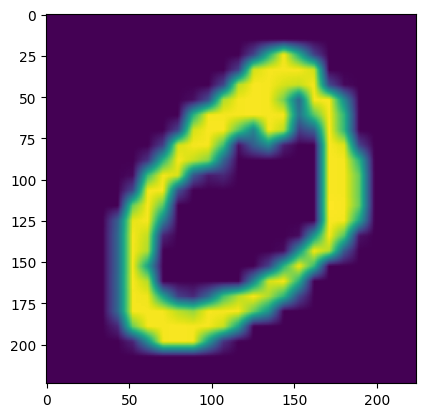

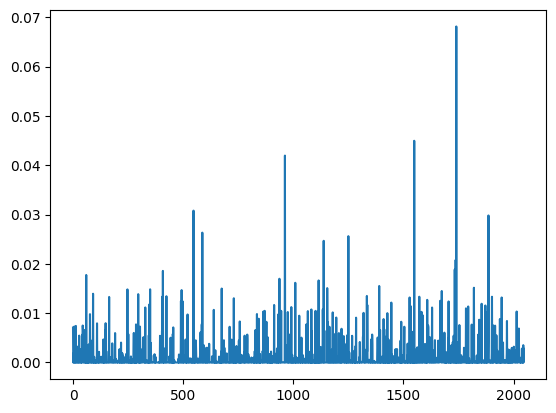

In [4]:
# input images of the same class
y = encode(model, digits[0][0]).numpy()[0]
print(y)
h_act = np.abs(y) > 0.01
print(np.sum(h_act))
im_ = digits[0][0].numpy()[0][0]

import matplotlib.pyplot as plt

plt.imshow(im_)
plt.figure()
plt.plot(y)

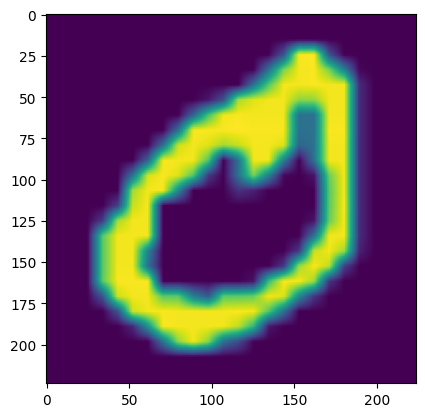

49


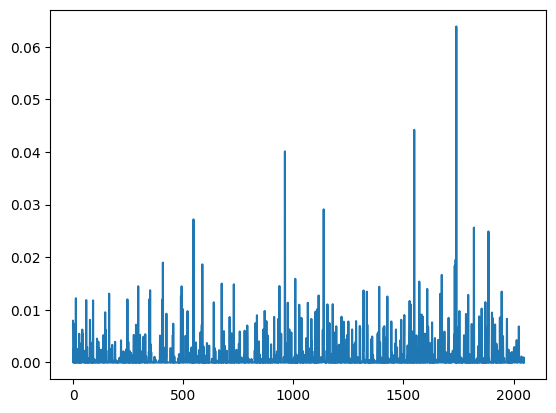

In [5]:
im_1 = digits[0][1].numpy()[0][0]
plt.imshow(im_1);plt.show()
y1 = encode(model, digits[0][1]).numpy()[0]
h_act1 = np.abs(y1) > 0.01
print(np.sum(h_act1))
plt.figure()
plt.plot(y1)

In [6]:
feats = np.logical_and(h_act, h_act1)
print(np.sum(feats))

46


[0, 2, 6, 13, 22, 28, 42, 44, 45, 60, 64, 72, 77, 81, 82, 91, 109, 118, 138, 146, 147, 148, 151, 163, 164, 178, 185, 192, 197, 218, 229, 247, 251, 263, 275, 276, 286, 288, 296, 304, 319, 320, 328, 332, 344, 347, 350, 353, 370, 395, 397, 404, 406, 408, 411, 416, 424, 443, 453, 455, 481, 490, 493, 498, 509, 511, 519, 520, 531, 547, 558, 559, 566, 569, 576, 579, 584, 585, 587, 593, 600, 618, 639, 675, 685, 686, 687, 688, 698, 711, 720, 730, 742, 753, 757, 779, 782, 791, 792, 810, 825, 828, 829, 830, 835, 843, 844, 864, 870, 871, 877, 878, 882, 884, 899, 913, 926, 932, 937, 939, 944, 961, 962, 968, 975, 982, 983, 985, 986, 1009, 1015, 1027, 1037, 1059, 1066, 1076, 1079, 1082, 1084, 1094, 1101, 1106, 1110, 1113, 1115, 1123, 1134, 1135, 1138, 1154, 1155, 1156, 1164, 1172, 1179, 1183, 1186, 1192, 1195, 1197, 1219, 1228, 1229, 1239, 1242, 1244, 1250, 1256, 1267, 1283, 1285, 1300, 1302, 1311, 1316, 1317, 1319, 1334, 1336, 1353, 1358, 1359, 1383, 1385, 1390, 1394, 1410, 1413, 1423, 1427, 1445, 1

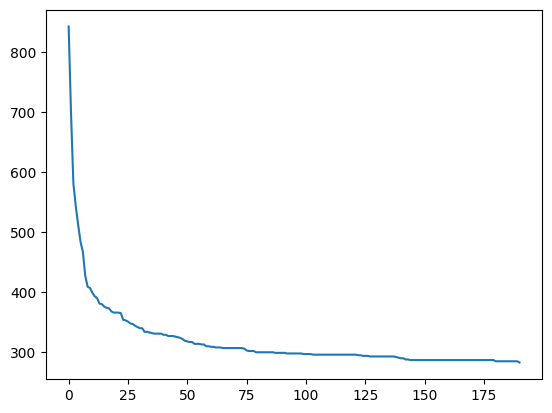

In [7]:
# do it massively
model.eval()
idx = 0
num_feats = 2048
feats = np.array([True]*num_feats)
n_common = np.zeros([len(digits[idx])])
for i in range(len(digits[idx])):
    y = encode(model, digits[idx][i]).numpy()[0]
    h_act = np.abs(y) > 0.000
    feats = np.logical_and(h_act, feats)
    n_common[i] = np.sum(feats)

# print all features selected
feats_sel = []
for i in range(num_feats):
    if feats[i]:
        feats_sel += [i]
print(feats_sel)
plt.plot(n_common)

[164, 296, 347, 408, 490, 675, 864, 962, 1390, 1533, 1572, 1667, 1674, 1733, 1737, 1740, 1794, 1872, 1886, 1946]


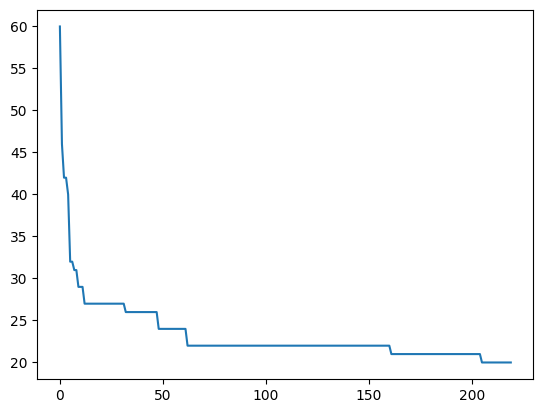

In [8]:
model.eval()
idx = 1
num_feats = 2048
feats = np.array([True]*num_feats)
n_common = np.zeros([len(digits[idx])])
for i in range(len(digits[idx])):
    y = encode(model, digits[idx][i]).numpy()[0]
    h_act = np.abs(y) > 0.01
    feats = np.logical_and(h_act, feats)
    n_common[i] = np.sum(feats)
# print all features selected
feats_sel = []
for i in range(num_feats):
    if feats[i]:
        feats_sel += [i]
print(feats_sel)
plt.plot(n_common)

In [9]:
feats1 = [164, 247, 296, 347, 408, 490, 493, 675, 962, 1009, 1390, 1549, 1667, 1674, 1733, 1737, 1740, 1872, 1886, 1946]
feats2 = [164, 296, 347, 408, 490, 675, 864, 962, 1390, 1533, 1572, 1667, 1674, 1733, 1737, 1740, 1794, 1872, 1886, 1946]

# remove common features and get distinct ones
a = b = 0
na = len(feats1)
nb = len(feats2)
cms = []
d1 = np.array([False]*na)
d2 = np.array([False]*nb)

while a < na and b < nb:
    if feats1[a]==feats2[b]:
        cms += [feats1[a]]
        d1[a] = True
        d2[b] = True
        a+=1
        b+=1
    elif feats1[a] > feats2[b]:
        b += 1
    else:
        a += 1
print(cms)

S1 = []
for i in range(na):
    if not d1[i]:
        S1 += [feats1[i]]
print(S1)
assert len(S1)+len(cms) == na

S2 = []
for i in range(nb):
    if not d2[i]:
        S2 += [feats2[i]]
print(S2)
assert len(S2)+len(cms) == nb

print(len(feats1))
print(len(feats2))


[164, 296, 347, 408, 490, 675, 962, 1390, 1667, 1674, 1733, 1737, 1740, 1872, 1886, 1946]
[247, 493, 1009, 1549]
[864, 1533, 1572, 1794]
20
20


In [12]:
feats1 = [0, 2, 6, 13, 22, 28, 42, 44, 45, 60, 64, 72, 77, 81, 82, 91, 109, 118, 138, 146, 147, 148, 151, 163, 164, 178, 185, 192, 197, 218, 229, 247, 251, 263, 275, 276, 286, 288, 296, 304, 319, 320, 328, 332, 344, 347, 350, 353, 370, 395, 397, 404, 406, 408, 411, 416, 424, 443, 453, 455, 481, 490, 493, 498, 509, 511, 519, 520, 531, 547, 558, 559, 566, 569, 576, 579, 584, 585, 587, 593, 600, 618, 639, 675, 685, 686, 687, 688, 698, 711, 720, 730, 742, 753, 757, 779, 782, 791, 792, 810, 825, 828, 829, 830, 835, 843, 844, 864, 870, 871, 877, 878, 882, 884, 899, 913, 926, 932, 937, 939, 944, 961, 962, 968, 975, 982, 983, 985, 986, 1009, 1015, 1027, 1037, 1059, 1066, 1076, 1079, 1082, 1084, 1094, 1101, 1106, 1110, 1113, 1115, 1123, 1134, 1135, 1138, 1154, 1155, 1156, 1164, 1172, 1179, 1183, 1186, 1192, 1195, 1197, 1219, 1228, 1229, 1239, 1242, 1244, 1250, 1256, 1267, 1283, 1285, 1300, 1302, 1311, 1316, 1317, 1319, 1334, 1336, 1353, 1358, 1359, 1383, 1385, 1390, 1394, 1410, 1413, 1423, 1427, 1445, 1456, 1463, 1471, 1487, 1490, 1504, 1528, 1530, 1533, 1542, 1547, 1549, 1559, 1563, 1568, 1572, 1579, 1581, 1582, 1587, 1598, 1608, 1612, 1613, 1620, 1630, 1643, 1658, 1665, 1667, 1672, 1674, 1686, 1703, 1705, 1717, 1722, 1724, 1728, 1731, 1733, 1737, 1739, 1740, 1742, 1744, 1754, 1762, 1765, 1767, 1774, 1775, 1777, 1784, 1787, 1794, 1798, 1810, 1815, 1817, 1818, 1820, 1839, 1844, 1855, 1872, 1875, 1880, 1885, 1886, 1902, 1905, 1914, 1915, 1916, 1922, 1924, 1934, 1938, 1941, 1946, 1952, 1970, 1973, 1982, 1996, 2002, 2007, 2008, 2013, 2014, 2024]
# using the found special features to validate the test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_path, train=False, transform=transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=8, shuffle=False,
    num_workers=2, pin_memory=False)

def XcontainsY(x, y):
    for a in y:
        if a not in x:
            return False
    return True

test_label = 0
true_accept = 0
false_accept = 0
true_reject = 0
false_reject = 0

model = model.cuda()

for _, (im, label) in enumerate(test_loader):
    im = im.cuda()
    y = encode(model, im).cpu().numpy()
    for i in range(y.shape[0]):
        h_act = np.abs(y[i]) > 0.000
        feats_sel = []
        for f in range(num_feats):
            if h_act[f]:
                feats_sel += [f]
        if XcontainsY(feats_sel, feats1):
            if label.numpy()[i] == test_label:
                true_accept += 1
            else:
                false_accept += 1
        else:
            if label.numpy()[i] == test_label:
                true_reject += 1
            else:
                false_reject += 1
print(true_accept)
print(false_accept)
print(true_reject)
print(false_reject)


918
2990
62
6030
